In [44]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# import dataset
df = pd.read_csv("data/gold.csv")

In [45]:
df = df.drop(columns=['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   gender               7043 non-null   object 
 1   SeniorCitizen        7043 non-null   object 
 2   Partner              7043 non-null   object 
 3   Dependents           7043 non-null   object 
 4   tenure               7043 non-null   int64  
 5   PhoneService         7043 non-null   object 
 6   MultipleLines        7043 non-null   object 
 7   InternetService      7043 non-null   object 
 8   Contract             7043 non-null   object 
 9   PaperlessBilling     7043 non-null   object 
 10  PaymentMethod        7043 non-null   object 
 11  MonthlyCharges       7043 non-null   float64
 12  TotalCharges         7043 non-null   float64
 13  Churn                7043 non-null   object 
 14  nb_service_internet  7043 non-null   int64  
dtypes: float64(2), int64(2), object(11)
me

In [46]:
from sklearn.model_selection import train_test_split
X = df.drop('Churn', axis=1)
y = df['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=True, random_state=42)

In [47]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()

y_train =  labelencoder.fit_transform(y_train)
y_test = labelencoder.transform(y_test)

In [48]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

categorial_features = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 
       'PhoneService', 'MultipleLines', 'InternetService','Contract', 'PaperlessBilling', 'PaymentMethod'
       ]

numerical_features = list(X.select_dtypes(include=[int,float]).columns)

categorical_transformer = OneHotEncoder(sparse_output=True)

numerical_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorial_features),
        ('num', numerical_transformer, numerical_features)
    ]
)

log_reg = LogisticRegression(penalty='l2', C=0.01)

pipe = Pipeline([
     ('preprocessor', preprocessor),
     ('log_reg', log_reg)
])

pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat', OneHotEncoder(),
                                                  ['gender', 'SeniorCitizen',
                                                   'Partner', 'Dependents',
                                                   'PhoneService',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'Contract',
                                                   'PaperlessBilling',
                                                   'PaymentMethod']),
                                                 ('num', StandardScaler(),
                                                  ['tenure', 'MonthlyCharges',
                                                   'TotalCharges',
                                                   'nb_service_internet'])])),
                ('log_reg', LogisticRegression(C=0.01))])

In [23]:
import mlflow

experiment_id = mlflow.set_experiment("churn_model").experiment_id

run_name = "reglog_C_small_stdscaler"

with mlflow.start_run(experiment_id=experiment_id, run_name=run_name) as run:
    # Log the baseline model to MLflow
    pipe.fit(X_train, y_train)
    
    
    mlflow.sklearn.log_model(pipe, run_name)

    
    model_uri = mlflow.get_artifact_uri(run_name)

    # Log des paramètres

    mlflow.log_param("C",0.8)

    # Log des Tags
    mlflow.set_tag("model","logistic_regression")
    mlflow.set_tag("regularisation",True)

    eval_data = X_test
    eval_data["label"] = y_test

    # Evaluate the logged model
    result = mlflow.evaluate(
        model_uri,
        eval_data,
        targets="label",
        model_type="classifier",
        evaluators=["default"],
    )

2023/05/15 13:44:49 INFO mlflow.models.evaluation.base: Evaluating the model with the default evaluator.
2023/05/15 13:44:49 INFO mlflow.models.evaluation.default_evaluator: The evaluation dataset is inferred as binary dataset, positive label is 1, negative label is 0.
2023/05/15 13:44:49 WARNING mlflow.models.evaluation.default_evaluator: Skip logging model explainability insights because the shap explainer None requires all feature values to be numeric, and each feature column must only contain scalar values.


In [24]:
y_pred_test = pipe.predict(X_test)
y_pred_train = pipe.predict(X_train)


In [25]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
print("######## accuracy_score : ")
print("TRAIN :",accuracy_score(y_train, y_pred_train))
print("TEST :",accuracy_score(y_test, y_pred_test))

print("######## precision_score : ")
print("TRAIN :",precision_score(y_train, y_pred_train))
print("TEST :",precision_score(y_test, y_pred_test))

print("######## recall_score : ")    
print("TRAIN :",recall_score(y_train, y_pred_train))
print("TEST :",recall_score(y_test, y_pred_test))

print("######## f1_score : ")
print("TRAIN :",f1_score(y_train, y_pred_train))
print("TEST :",f1_score(y_test, y_pred_test))

######## accuracy_score : 
TRAIN : 0.7983670571529996
TEST : 0.8140525195173882
######## precision_score : 
TRAIN : 0.6682242990654206
TEST : 0.6989247311827957
######## recall_score : 
TRAIN : 0.47794117647058826
TEST : 0.5227882037533512
######## f1_score : 
TRAIN : 0.5572876071706937
TEST : 0.5981595092024541


<Figure size 1050x700 with 0 Axes>

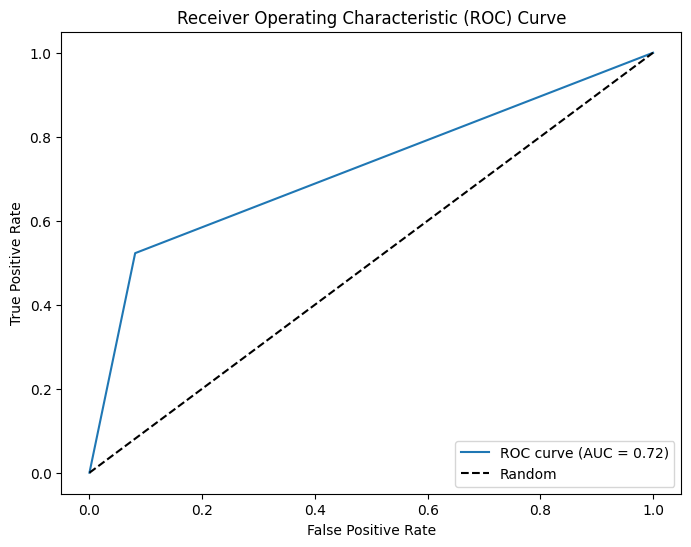

######## roc_auc_score : 
TRAIN : 0.6960754698206011
TEST : 0.7208535613361351


In [26]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score


# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test)

# Calculate the area under the ROC curve (AUC)
auc = roc_auc_score(y_test, y_pred_test)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(auc))
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

print("######## roc_auc_score : ")    
print("TRAIN :",roc_auc_score(y_train, y_pred_train))
print("TEST :",roc_auc_score(y_test, y_pred_test))  



## Cross-validation

In [27]:
log_rev_cv = LogisticRegressionCV(cv=5)

pipe_cv = Pipeline([
     ('preprocessor', preprocessor),
     ('log_reg', log_rev_cv)
])

pipe_cv

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat', OneHotEncoder(),
                                                  ['gender', 'SeniorCitizen',
                                                   'Partner', 'Dependents',
                                                   'PhoneService',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'Contract',
                                                   'PaperlessBilling',
                                                   'PaymentMethod']),
                                                 ('num', StandardScaler(),
                                                  ['tenure', 'MonthlyCharges',
                                                   'TotalCharges',
                                                   'nb_service_internet'])])),
                ('log_reg', LogisticRegressionCV(cv=5))])

In [28]:
experiment_id = mlflow.set_experiment("churn_model").experiment_id

run_name = "reglog_cv"

with mlflow.start_run(experiment_id=experiment_id, run_name=run_name) as run:
    # Log the baseline model to MLflow
    pipe_cv.fit(X_train, y_train)
    
    
    mlflow.sklearn.log_model(pipe_cv, run_name)

    
    model_uri = mlflow.get_artifact_uri(run_name)

    # Log des paramètres

    mlflow.log_param("C",0.8)

    # Log des Tags
    mlflow.set_tag("model","logistic_regression")
    mlflow.set_tag("regularisation",True)

    eval_data = X_test
    eval_data["label"] = y_test

    # Evaluate the logged model
    result = mlflow.evaluate(
        model_uri,
        eval_data,
        targets="label",
        model_type="classifier",
        evaluators=["default"],
    )

2023/05/15 13:44:52 INFO mlflow.models.evaluation.base: Evaluating the model with the default evaluator.
2023/05/15 13:44:52 INFO mlflow.models.evaluation.default_evaluator: The evaluation dataset is inferred as binary dataset, positive label is 1, negative label is 0.
2023/05/15 13:44:52 WARNING mlflow.models.evaluation.default_evaluator: Skip logging model explainability insights because the shap explainer None requires all feature values to be numeric, and each feature column must only contain scalar values.


In [29]:
pipe_cv.score(X_test, y_test)

0.8197303051809794

## Grid search / Randomized

In [83]:
#Afficher le nom des params du pipeline afin de les utiliser dans un grid search
pipe.get_params()

{'memory': None,
 'steps': [('preprocessor',
   ColumnTransformer(transformers=[('cat', OneHotEncoder(),
                                    ['gender', 'SeniorCitizen', 'Partner',
                                     'Dependents', 'PhoneService', 'MultipleLines',
                                     'InternetService', 'Contract',
                                     'PaperlessBilling', 'PaymentMethod']),
                                   ('num', StandardScaler(),
                                    ['tenure', 'MonthlyCharges', 'TotalCharges',
                                     'nb_service_internet'])])),
  ('log_reg', LogisticRegression(C=1, penalty='l1', solver='saga'))],
 'verbose': False,
 'preprocessor': ColumnTransformer(transformers=[('cat', OneHotEncoder(),
                                  ['gender', 'SeniorCitizen', 'Partner',
                                   'Dependents', 'PhoneService', 'MultipleLines',
                                   'InternetService', 'Contract',
 

In [32]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score

# paras qu'on veut tester
# la syntax log_reg__x est lié au fait qu'on utilise un pipeline
# pour avoir la liste des params, on peut utiliser la méthode .get_params() ci_dessus
params = {
    'log_reg__penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'log_reg__C': np.arange(1,11),
    'log_reg__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

## 200 combinaisons

# Créer un objet GridSearchCV avec votre pipeline, les paramètres que vous voulez tester, et la métrique de performance que vous voulez utiliser
grid_search = GridSearchCV(pipe, params, cv=5, scoring='f1', refit='f1')

grid_search.fit(X_train, y_train)
print(grid_search.cv_results_) # pr voir tous les resultats

print("Best parameters: ", grid_search.best_params_)

# Utiliser le meilleur modèle pour faire des prédictions sur les données de test
y_pred_test = grid_search.predict(X_test)
#va faire des predictions sur y_test
score_test = grid_search.score(X_test, y_test)
#évalue la performance du modéle en donnant le y test

#score = model.score(X_train, y_train, X_test, y_test)
# Afficher la métrique de performance ROC AUC pour le meilleur modèle sur les données de test
print("F1 score :", f1_score(y_test, y_pred_test))

/opt/miniconda3/envs/ml_api/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/ml_api/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/ml_api/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/ml_api/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/ml_api/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/ml_api/lib/python3.

{'mean_fit_time': array([0.00971985, 0.00788155, 0.14542947, 0.01125612, 0.07812853,
       0.05515885, 0.05451899, 0.02081041, 0.11227598, 0.12160993,
       0.01166449, 0.01453309, 0.01175766, 0.01247396, 0.00833702,
       0.04816766, 0.03126664, 0.01106482, 0.03636179, 0.08458147,
       0.03755984, 0.01397085, 0.22413859, 0.01637936, 0.09515166,
       0.0568562 , 0.05915084, 0.02124324, 0.11678967, 0.11252999,
       0.01298542, 0.00825076, 0.01354094, 0.01326013, 0.00924888,
       0.06263299, 0.02866378, 0.00820699, 0.04140615, 0.06607761,
       0.0127172 , 0.01131439, 0.2798667 , 0.01317587, 0.08971786,
       0.05815778, 0.04499416, 0.02450175, 0.13358674, 0.1273376 ,
       0.01303186, 0.01609106, 0.01640201, 0.00967431, 0.00828104,
       0.04810476, 0.04072719, 0.01221604, 0.06440573, 0.09643345,
       0.01367168, 0.01335955, 0.37838373, 0.01267719, 0.12354956,
       0.05387564, 0.03833265, 0.0232152 , 0.13072276, 0.12103915,
       0.01222706, 0.01405888, 0.01326728, 0

In [34]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

param_dist = {
    'log_reg__penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'log_reg__C': np.arange(1e-4,1e3),
    'log_reg__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

#  objet RandomizedSearchCV, la distribution d'hyperparamètres que vous voulez tester, le nombre d'itérations que vous voulez faire et la métrique de performance que vous voulez utiliser
random_search = RandomizedSearchCV(pipe, param_distributions=param_dist, n_iter=100, cv=5, scoring='f1')

# Faire tourner le RandomizedSearchCV
random_search.fit(X_train, y_train)

# Récupérer les meilleurs paramètres trouvés 
best_params_random = random_search.best_params_
print(best_params_random) #on a un dictionnaire avec en clés les hyperparamètres sur lesquels on a demandé d'agir

print (random_search.best_params_
       )
# Définir une nouvelle grille de paramètres centrée sur les meilleurs paramètres trouvés par RandomizedSearchCV
params = {
    'log_reg__penalty': [best_params_random['log_reg__penalty']],
    'log_reg__C': [
        best_params_random['log_reg__C'] - best_params_random['log_reg__C']/10,
        best_params_random['log_reg__C'],
        best_params_random['log_reg__C'] + best_params_random['log_reg__C']/10],
    'log_reg__solver': [best_params_random['log_reg__solver']]
}


grid_search = GridSearchCV(pipe, params, cv=5, scoring='f1')

grid_search.fit(X_train, y_train)

print("Best parameters: ", grid_search.best_params_)

# Utiliser le meilleur modèle pour faire des prédictions sur les données de test
y_pred_test = grid_search.predict(X_test)

print("f1 score:", roc_auc_score(y_test, y_pred_test))

/opt/miniconda3/envs/ml_api/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/opt/miniconda3/envs/ml_api/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/miniconda3/envs/ml_api/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/opt/miniconda3/envs/ml_api/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/miniconda3/envs/ml_api/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='no

{'log_reg__solver': 'newton-cg', 'log_reg__penalty': 'l2', 'log_reg__C': 24.0001}
{'log_reg__solver': 'newton-cg', 'log_reg__penalty': 'l2', 'log_reg__C': 24.0001}
Best parameters:  {'log_reg__C': 21.60009, 'log_reg__penalty': 'l2', 'log_reg__solver': 'newton-cg'}
f1 score: 0.7468040618174666


## Courbes de validation

<Figure size 1050x700 with 0 Axes>

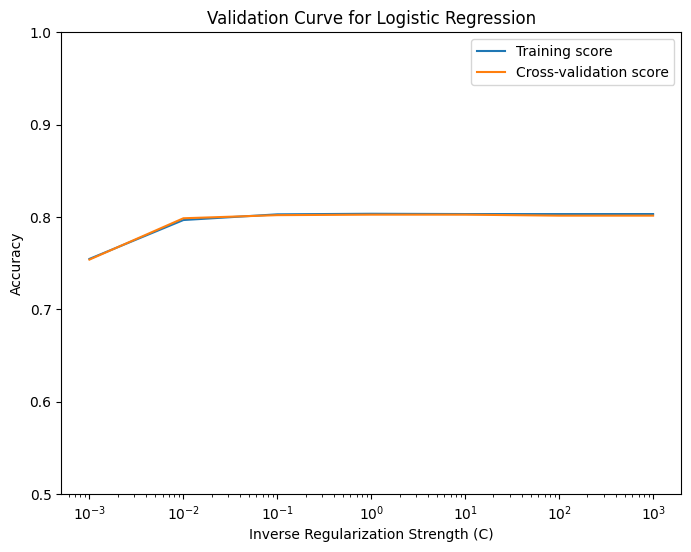

In [35]:
# Importer les librairies requises
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import validation_curve

# Définir une plage de valeurs pour l'hyperparamètre, ici C
param_range = np.logspace(-3, 3, 7)

# Calculer les scores de validation croisée pour chaque valeur de l'hyperparamètre
train_scores, valid_scores = validation_curve(
    pipe, X_train, y_train, 
    param_name='log_reg__C', 
    param_range=param_range,
    cv=5, scoring="accuracy"        #"f1", "recall", "roc_auc"
)

# Calculer la moyenne des scores d'entraînement et de validation pour chaque valeur de l'hyperparamètre
train_mean = np.mean(train_scores, axis=1)
valid_mean = np.mean(valid_scores, axis=1)

# Tracer la courbe de validation
plt.figure(figsize=(8, 6))
plt.title("Validation Curve for Logistic Regression")
plt.xlabel("Inverse Regularization Strength (C)")
plt.ylabel("Accuracy")
plt.ylim(0.5, 1.0)

plt.semilogx(param_range, train_mean, label="Training score")
plt.semilogx(param_range, valid_mean, label="Cross-validation score")

plt.legend(loc="best")
plt.show()

## SVM

In [36]:
from sklearn.svm import LinearSVC
svc = LinearSVC(C=1)
pipe_svc = Pipeline([
     ('preprocessor', preprocessor),
     ('svc', svc)
])

experiment_id = mlflow.set_experiment("churn_model").experiment_id

run_name = "reglog_svc"

with mlflow.start_run(experiment_id=experiment_id, run_name=run_name) as run:
    # Log the baseline model to MLflow
    pipe_svc.fit(X_train, y_train)
    
    
    mlflow.sklearn.log_model(pipe_svc, run_name)

    
    model_uri = mlflow.get_artifact_uri(run_name)

    # Log des paramètres

    mlflow.log_param("C",1)

    # Log des Tags
    mlflow.set_tag("model","svc")
    mlflow.set_tag("regularisation",True)

    eval_data = X_test
    eval_data["label"] = y_test

    # Evaluate the logged model
    result = mlflow.evaluate(
        model_uri,
        eval_data,
        targets="label",
        model_type="classifier",
        evaluators=["default"],
    )

2023/05/15 13:46:28 INFO mlflow.models.evaluation.base: Evaluating the model with the default evaluator.
2023/05/15 13:46:28 INFO mlflow.models.evaluation.default_evaluator: The evaluation dataset is inferred as binary dataset, positive label is 1, negative label is 0.
2023/05/15 13:46:29 WARNING mlflow.models.evaluation.default_evaluator: Skip logging model explainability insights because the shap explainer None requires all feature values to be numeric, and each feature column must only contain scalar values.


## Naïve Bayes

In [37]:
from sklearn.naive_bayes import GaussianNB,MultinomialNB,CategoricalNB

nb = GaussianNB()
pipe_nb = Pipeline([
     ('preprocessor', preprocessor),
     ('nb', nb)
])

experiment_id = mlflow.set_experiment("churn_model").experiment_id

run_name = "reglog_nb"

with mlflow.start_run(experiment_id=experiment_id, run_name=run_name) as run:
    # Log the baseline model to MLflow
    pipe_nb.fit(X_train, y_train)
    
    
    mlflow.sklearn.log_model(pipe_nb, run_name)

    
    model_uri = mlflow.get_artifact_uri(run_name)

    # Log des paramètres

    mlflow.log_param("C",1)

    # Log des Tags
    mlflow.set_tag("model","nb")
    mlflow.set_tag("regularisation",True)

    eval_data = X_test
    eval_data["label"] = y_test

    # Evaluate the logged model
    result = mlflow.evaluate(
        model_uri,
        eval_data,
        targets="label",
        model_type="classifier",
        evaluators=["default"],
    )

2023/05/15 13:46:30 INFO mlflow.models.evaluation.base: Evaluating the model with the default evaluator.
2023/05/15 13:46:30 INFO mlflow.models.evaluation.default_evaluator: The evaluation dataset is inferred as binary dataset, positive label is 1, negative label is 0.
2023/05/15 13:46:31 WARNING mlflow.models.evaluation.default_evaluator: Skip logging model explainability insights because the shap explainer None requires all feature values to be numeric, and each feature column must only contain scalar values.


In [38]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
pipe_knn = Pipeline([
     ('preprocessor', preprocessor),
     ('knn', knn)
])

experiment_id = mlflow.set_experiment("churn_model").experiment_id

run_name = "reglog_knn"

with mlflow.start_run(experiment_id=experiment_id, run_name=run_name) as run:
    # Log the baseline model to MLflow
    pipe_knn.fit(X_train, y_train)
    
    
    mlflow.sklearn.log_model(pipe_knn, run_name)

    
    model_uri = mlflow.get_artifact_uri(run_name)

    # Log des paramètres

    mlflow.log_param("C",1)

    # Log des Tags
    mlflow.set_tag("model","nb")
    mlflow.set_tag("regularisation",True)

    eval_data = X_test
    eval_data["label"] = y_test

    # Evaluate the logged model
    result = mlflow.evaluate(
        model_uri,
        eval_data,
        targets="label",
        model_type="classifier",
        evaluators=["default"],
    )

2023/05/15 13:46:32 INFO mlflow.models.evaluation.base: Evaluating the model with the default evaluator.
2023/05/15 13:46:32 INFO mlflow.models.evaluation.default_evaluator: The evaluation dataset is inferred as binary dataset, positive label is 1, negative label is 0.
2023/05/15 13:46:33 WARNING mlflow.models.evaluation.default_evaluator: Skip logging model explainability insights because the shap explainer None requires all feature values to be numeric, and each feature column must only contain scalar values.


## Decision Tree

In [39]:
from sklearn.tree import DecisionTreeClassifier

pipe = Pipeline([
     ('preprocessor', preprocessor),
     ('dt', DecisionTreeClassifier(random_state=42))
])

pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat', OneHotEncoder(),
                                                  ['gender', 'SeniorCitizen',
                                                   'Partner', 'Dependents',
                                                   'PhoneService',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'Contract',
                                                   'PaperlessBilling',
                                                   'PaymentMethod']),
                                                 ('num', StandardScaler(),
                                                  ['tenure', 'MonthlyCharges',
                                                   'TotalCharges',
                                                   'nb_service_internet'])])),
                ('dt', DecisionTreeClassifier(random_state=42))])

## Random Forest

In [42]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier

# Définir les colonnes catégorielles et numériques
categorial_features = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 
       'PhoneService', 'MultipleLines', 'InternetService','Contract', 'PaperlessBilling', 'PaymentMethod'
       ]

# numerical_features = ['tenure', 'MonthlyCharges', 'TotalCharges','nb_service_internet']
numerical_features = list(X.select_dtypes(include=[int,float]).columns)

# Définir les transformateurs de prétraitement pour les colonnes catégorielles et numériques
categorical_transformer = OneHotEncoder(handle_unknown='ignore')
numerical_transformer = StandardScaler()

# Définir la ColumnTransformer pour appliquer les transformateurs aux colonnes catégorielles et numériques
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorial_features),
        ('num', numerical_transformer, numerical_features)
    ]
)
# Définir le modèle Random Forest Classifier
rf_model = RandomForestClassifier()

# Définir le pipeline avec la ColumnTransformer et le modèle
pipe = Pipeline(steps=[
    ('preprocessor', preprocessor), 
    ('rf_model', rf_model)])
pipe


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['gender', 'SeniorCitizen',
                                                   'Partner', 'Dependents',
                                                   'PhoneService',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'Contract',
                                                   'PaperlessBilling',
                                                   'PaymentMethod']),
                                                 ('num', StandardScaler(),
                                                  ['tenure', 'MonthlyCharges',
                                                   'TotalCharges',
                                                   'nb_service_internet'])])),
                ('rf_model', RandomForestClassifier())])

In [43]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score

# Définir la grille des hyperparamètres à rechercher
param_grid = {'rf_modeln_estimators': [100, 200],
              'rf_modelmax_depth': [5, 10],
              'rf_modelmin_samples_split': [2, 5, 10],
              'rf_modelmin_samples_leaf': [1, 2, 4],
              'rf_modelmax_features': ['sqrt', 'log2', None],
              'rf_modelcriterion': ['gini', 'entropy']}

# Créer l'objet de recherche aléatoire
rf_random = RandomizedSearchCV(pipe, param_distributions=param_grid, n_iter=10, cv=5, random_state=42)

# Lancer la recherche aléatoire
rf_random.fit(X_train, y_train)
#####################################
# Récupérer les meilleurs paramètres trouvés 
best_params_random = rf_random.bestparams
print(best_params_random) #on a un dictionnaire avec en clés les hyperparamètres sur lesquels on a demandé d'agir

print (rf_random.bestparams
       )
# Définir une nouvelle grille de paramètres centrée sur les meilleurs paramètres trouvés par RandomizedSearchCV
params = {
    'rf_modeln_estimators': [best_params_random['rf_modeln_estimators']],
    'rf_modelmax_depth': [best_params_random['rf_modelmax_depth']],
    'rf_modelmin_samples_split': [best_params_random['rf_modelmin_samples_split']],
    'rf_modelmin_samples_leaf': [best_params_random['rf_modelmin_samples_leaf']],
    'rf_modelmax_features': [best_params_random['rf_modelmax_features']],
    'rf_modelcriterion': [best_params_random['rf_modelcriterion']]
}
grid_search = GridSearchCV(pipe, params, cv=5, scoring='f1')

grid_search.fit(X_train, y_train)

print("Best parameters: ", grid_search.bestparams)

# Calculate the ROC AUC score on the test set
y_pred_proba = grid_search.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Print the ROC AUC score
# print(f"ROC AUC score on the test set: {roc_auc:.4f}")
print("f1 score:", roc_auc_score(y_test, y_pred_proba))

ValueError: Invalid parameter 'rf_modeln_estimators' for estimator Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['gender', 'SeniorCitizen',
                                                   'Partner', 'Dependents',
                                                   'PhoneService',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'Contract',
                                                   'PaperlessBilling',
                                                   'PaymentMethod']),
                                                 ('num', StandardScaler(),
                                                  ['tenure', 'MonthlyCharges',
                                                   'TotalCharges',
                                                   'nb_service_internet'])])),
                ('rf_model', RandomForestClassifier())]). Valid parameters are: ['memory', 'steps', 'verbose'].

## Adaboost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier(random_state=42)

## Catboost

In [ ]:
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

# Charger le dataframe
df = pd.read_csv('data/gold.csv')

# Convertir les valeurs de la colonne Churn en 0 ou 1
df['Churn'] = df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)

# Définir les features catégorielles et numériques
categorical_features = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
numerical_features = ['tenure', 'MonthlyCharges', 'TotalCharges', 'nb_service_internet']

# Séparer les features et la target
X = df.drop(['Churn'], axis=1)
y = df['Churn']

# Fractionner les données en train et test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Créer un objet CatBoostClassifier
model = CatBoostClassifier(silent=True)

# Définir les hyperparamètres à tester
params = {
    'iterations': [10, 50, 100],
    'learning_rate': [0.1, 0.5, 1],
    'depth': [2, 4, 6],
}

# Créer un objet GridSearchCV
grid_search = GridSearchCV(model, param_grid=params, cv=5)

# Entrainer le modèle avec GridSearchCV
grid_search.fit(X_train, y_train, cat_features=categorical_features)

# Afficher les meilleurs hyperparamètres et le score obtenu
print('Meilleurs hyperparamètres :', grid_search.best_params_)
print('Score :', grid_search.best_score_)

y_pred_test = grid_search.predict(X_test)
y_pred_train = grid_search.predict(X_train)

## Feature Selector

In [51]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression

categorial_features = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 
       'PhoneService', 'MultipleLines', 'InternetService','Contract', 'PaperlessBilling', 'PaymentMethod'
       ]

numerical_features = list(X.select_dtypes(include=[int,float]).columns)

categorical_transformer = OneHotEncoder(sparse_output=True)

numerical_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorial_features),
        ('num', numerical_transformer, numerical_features)
    ]
)

log_reg = LogisticRegression(penalty='l1', C=1, solver='saga')

pipe = Pipeline([
     ('preprocessor', preprocessor),
     ('log_reg', log_reg)
])

pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat', OneHotEncoder(),
                                                  ['gender', 'SeniorCitizen',
                                                   'Partner', 'Dependents',
                                                   'PhoneService',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'Contract',
                                                   'PaperlessBilling',
                                                   'PaymentMethod']),
                                                 ('num', StandardScaler(),
                                                  ['tenure', 'MonthlyCharges',
                                                   'TotalCharges',
                                                   'nb_service_internet'])])),
                ('log_reg',
                 LogisticRegression(C=1, penalty='l1', solver='saga'))])

In [52]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat', OneHotEncoder(),
                                                  ['gender', 'SeniorCitizen',
                                                   'Partner', 'Dependents',
                                                   'PhoneService',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'Contract',
                                                   'PaperlessBilling',
                                                   'PaymentMethod']),
                                                 ('num', StandardScaler(),
                                                  ['tenure', 'MonthlyCharges',
                                                   'TotalCharges',
                                                   'nb_service_internet'])])),
                ('log_reg',
                 LogisticRegression(C=1, penalty='l1', solver='saga'))])

In [74]:
columns = pd.concat([pd.get_dummies(X_train[categorial_features]),
           X_train[numerical_features]], axis=1).columns

In [77]:
pd.DataFrame(data=pipe[1].coef_, columns=columns)

,gender_Female,gender_Male,SeniorCitizen_No,SeniorCitizen_Yes,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,PhoneService_No,PhoneService_Yes,...,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,tenure,MonthlyCharges,TotalCharges,nb_service_internet
0,0.002748,-0.039847,-0.175804,0.002429,-0.041062,0.002506,0.002414,-0.15729,0.393083,-1.023417,...,-0.346995,0.002353,0.00122,-0.070168,0.351963,-0.034788,-1.378144,1.65395,0.673064,-0.824754


## Learning curves

/opt/miniconda3/envs/ml_api/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/ml_api/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/ml_api/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


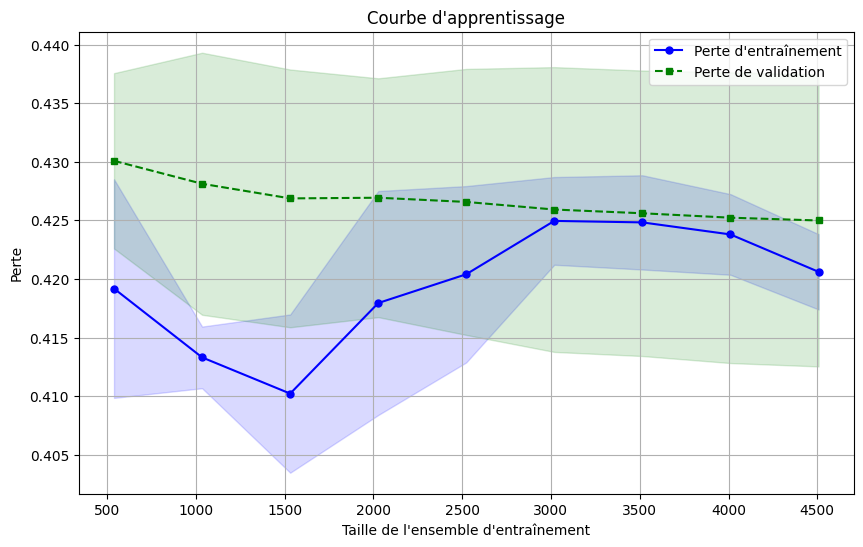

In [82]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(pipe, X_train, y_train, train_sizes=np.linspace(0.01, 1.0, 10)[1:], cv=5, scoring='neg_log_loss')

train_mean = -np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = -np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label="Perte d'entraînement")
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label="Perte de validation")
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.title("Courbe d'apprentissage")
plt.xlabel("Taille de l'ensemble d'entraînement")
plt.ylabel('Perte')
# plt.ylim([0,1.0])
plt.legend(loc='upper right')
plt.grid(True)
plt.show()
# plt.savefig('loss.png')


/opt/miniconda3/envs/ml_api/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/ml_api/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/ml_api/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


<Figure size 1050x700 with 0 Axes>

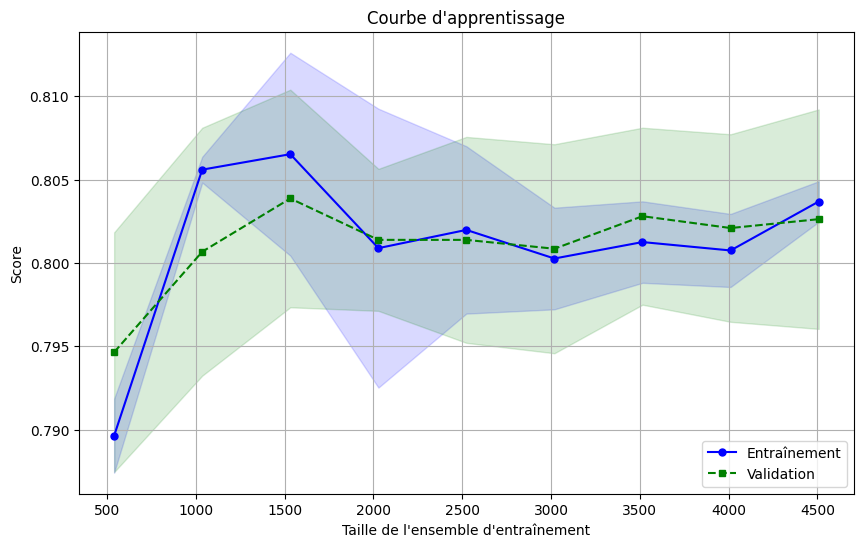

In [81]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(pipe, X_train, y_train, train_sizes=np.linspace(0.01, 1.0, 10)[1:], cv=5)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Entraînement')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='Validation')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.title("Courbe d'apprentissage")
plt.xlabel("Taille de l'ensemble d'entraînement")
plt.ylabel('Score')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
# plt.savefig('score.png')